## Import

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [3]:
import datetime
import json

## Open files

In [290]:
# Add income of UA budget
with open('data/budget_income.json') as b:
    budget_income_dict = json.loads(b.read())
    
# Add expenses of UA budget
with open('data/budget_expenses.json') as b_e:
    budget_expenses_dict = json.loads(b_e.read())
    
# Add consumer price index
with open('data/inflation.json', 'r') as inf:
    inflation_dict = json.loads(inf.read())
    
# Add incomes of all Ukrainian banks, except of NBU
with open('data/bank_inc.json', 'r') as bank_inc:
    bank_income_dict = json.loads(bank_inc.read())

# Add expenses of all Ukrainian banks, except of NBU
with open('data/bank_exp.json', 'r') as bank_exp:
    bank_expenses_dict = json.loads(bank_exp.read())
    
# Add amount of Ukrainian export
with open('data/export.json', 'r') as export:
    ua_export_dict = json.loads(export.read())
    
# Add amount of Ukrainian import
with open('data/import.json', 'r') as ua_imp:
    ua_import_dict = json.loads(ua_imp.read())
    
# Add gross external debt
with open('data/grossextdebt.json', 'r') as debt:
    grossextdebt_dict = json.loads(debt.read())

# Add Ukrainian GDP
with open('data/vvp.json', 'r') as gdp:
    gross_domestic_product_dict = json.loads(gdp.read())

# Add trends of exchange interest
df_interest_trend = pd.read_csv('data/kurs.csv')

# Add exchange rate UAH to USD
exchange_rate = pd.read_csv('data/exchange_rate.csv')

## Define a function to clean data from useless information

In [326]:
def df_cleaner(new_dict):
    
    # We need only these three columns
    new_cols = ['freq', 'value', 'date']
    df = pd.DataFrame(new_dict)
    
    #  A condition to choose only absolute values of import/export
    if df['tzep'][0] == 'F_':
        df = df.where(df['tzep'] == 'F_')
     
    # Rename columns
    df.rename(columns={'dt' : 'date'}, inplace = True)
    df.rename(columns={'value' : df['txt'][0]})
    df['date'] = pd.to_datetime(df['date'])
    df = df.sort_values(by='date')
    
    # Throw away useless columns
    for col in list(df.columns.values):
        if col not in new_cols:
            df = df.drop(col, axis=1)
    
    # Return clean data
    return df


## Define function to leave data of chosen frequency

In [329]:
def to_frequency(dataframe, frequency = 'M'):
    dataframe = dataframe.where(dataframe['freq'] == frequency)
    dataframe = dataframe.dropna(axis=0, how='all')
    dataframe.index = range(len(dataframe))
    return dataframe

# Preprocessing
## Clean and regroup the data about inflation in Ukraine

In [330]:
# Special function to 
def select_total(dictionary):
    df = pd.DataFrame(dictionary)
    
    # 'ku' - for region of Ukraine. I choose 'ku' == None and change it 
    # to the value 100500, which is out of range of Ukrainian regions.
    # 'tzep' - for absolute values.
    df.fillna(value='100500', inplace=True)
    df = df.where(df['ku'] == '100500')
    df = df.where(df['tzep'] == 'DTPY_')  
    
    # Rename columns
    df.rename(columns={'dt' : 'date'}, inplace = True)
    df.rename(columns={'value' : df['txten'][0]})
    
    # Convert date column to datetime type and sort data by date
    df['date'] = pd.to_datetime(df['date'])
    df = df.sort_values(by='date')
    df = df.where(df['mcrd081'] == 'Total').dropna(axis=0, how='all')
    
    # Delete all the useless information
    new_cols = ['freq', 'value', 'date']
    for col in list(df.columns.values):
        if col not in new_cols:
            df = df.drop(col, axis=1)
                         
    # Return 
    return df

##  Define the dataset

In [448]:
# Define dataset
df_budget_income = to_frequency(df_cleaner(budget_income_dict), 'M')

df_budget_expenses = to_frequency(df_cleaner(budget_expenses_dict), 'M')

df_bank_income = to_frequency(df_cleaner(bank_income_dict), 'M')

df_bank_expenses = to_frequency(df_cleaner(bank_expenses_dict), 'M')

df_import = to_frequency(df_cleaner(ua_import_dict), 'Q') # pd.DataFrame(ua_import_dict) 
                          
df_export = to_frequency(df_cleaner(ua_export_dict), 'Q') # pd.DataFrame(ua_export_dict)
                         
df_grossextdebt = to_frequency(df_cleaner(grossextdebt_dict), 'Q')
                         
df_gdp = to_frequency(df_cleaner(gross_domestic_product_dict), 'Q') # pd.DataFrame(gross_domestic_product_dict)

df_inflation = to_frequency(select_total(inflation_dict), 'M') #pd.DataFrame(inflation_dict) 

df_interest_trend = df_interest_trend.rename(columns={'Month' : 'date', 'курс валют: (Ukraine)' : 'interest rate'})
df_interest_trend['date'] = pd.to_datetime(df_interest_trend['date'])

gdp_2017 = pd.read_csv('data/UkraineGDP.csv')

## Create new pandas dataframe to collect all the data

In [336]:
df_total = exchange_rate.copy()

#### Set date as an index

In [337]:
df_total['date'] = pd.to_datetime(df_total['date'])
df_total = df_total.set_index('date')

#### Cut off data for 1998-2009

In [449]:
df_total = df_total.loc[datetime.datetime(2010,1,1):datetime.datetime.now()]

### 1. Gross domestic product

#### Set date as index

In [373]:
gdp_2017['freq'] = 'Q'
gdp_2017['date'] = pd.to_datetime(gdp_2017['date'])
gdp_2017 = gdp_2017.set_index('date')
df_gdp = df_gdp.set_index('date')

I did't have enough data about Ukrainian GDP, so I make an assumption, that GDP growth in 2018 (comparing with 2017) is 3.1%. In fact, the value 3.1% was taken here
https://news.finance.ua/ua/news/-/417573/vvp-ukrayiny-prognozy-na-2018
The same issue had been concerning the quartal data for the beginning of 2010, so I've taken value for 2011 and substracted the growth of GDP in 2010.

In [375]:
df_gdp = df_gdp.append(gdp_2017[1:])
df_gdp.loc[datetime.datetime(2010,1,1)] = ['Q', df_gdp['value'][datetime.datetime(2010,4,1)] * (1-0.042)]
df_gdp.loc[datetime.datetime(2018,1,1)] = ['Q', gdp_2017['value'][datetime.datetime(2017,1,1)] * 1.034]
df_gdp.loc[datetime.datetime(2018,4,1)] = ['Q', gdp_2017['value'][datetime.datetime(2017,4,1)] * 1.034]
df_gdp = df_gdp.sort_index()

#### Change frequency of GDP to daily, missing values are replaced with interpolated

In [376]:
df_gdp = df_gdp.asfreq('D')

In [377]:
df_gdp = df_gdp.apply(pd.Series.interpolate)

#### Add GDP value to collective dataframe

In [379]:
df_total['gdp'] = df_gdp['value']

#### Include GDP in USD to the collective dataframe

In [459]:
df_total['gdp_in_usd'] = df_total['gdp'].divide(df_total['exchange rate'])

In [460]:
df_total

,exchange rate,gdp,gdp_in_usd
date,,,
2010-01-01,7.985000,207956.892000,26043.442956
2010-01-02,7.985000,208058.193200,26056.129393
2010-01-03,7.985000,208159.494400,26068.815830
2010-01-04,7.985000,208260.795600,26081.502267
2010-01-05,7.985000,208362.096800,26094.188704
2010-01-06,7.985000,208463.398000,26106.875141
2010-01-07,7.985000,208564.699200,26119.561578
2010-01-08,7.985000,208666.000400,26132.248015
2010-01-09,7.985000,208767.301600,26144.934452


#### The difference between GDP in UAH and USD.

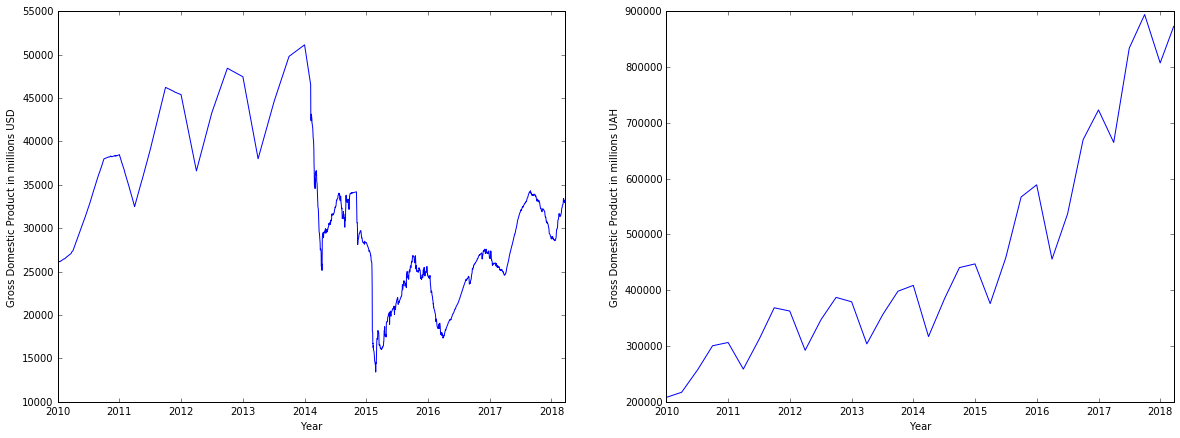

In [444]:
plt.figure(figsize=[20,7])
plt.subplot(1,2,1)
plt.plot(df_total['gdp_in_usd'])
plt.xlabel('Year')
plt.ylabel("Gross Domestic Product in millions USD")
plt.subplot(1,2,2)
plt.xlabel('Year')
plt.ylabel("Gross Domestic Product in millions UAH")
plt.plot(df_total['gdp'])
plt.show()

In [168]:
df_total.isnull().sum()

exchange rate       0
gdp              4645
dtype: int64